In [17]:
#import pandas and sqlite
import pandas as pd
import sqlite3 as sl

In [18]:
#connecct to database object
conn = sl.connect('NYT_covid.db')
c = conn.cursor()

In [19]:
#confirm tables present
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

deaths
mask_use
states
us
election
counties
regions


In [20]:
#update counties table with most recent data
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS counties')
c.execute('CREATE TABLE counties (date datetime, county str, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

counties.to_sql('counties',conn, if_exists='replace')

In [21]:
df = pd.read_sql('''SELECT * FROM counties WHERE state = 'Illinois' AND county = 'Cook' ORDER by date asc''',conn)
df

,date,county,state,fips,cases,deaths
0,2020-01-24,Cook,Illinois,17031.0,1,0
1,2020-01-25,Cook,Illinois,17031.0,1,0
2,2020-01-26,Cook,Illinois,17031.0,1,0
3,2020-01-27,Cook,Illinois,17031.0,1,0
4,2020-01-28,Cook,Illinois,17031.0,1,0
...,...,...,...,...,...,...
278,2020-10-28,Cook,Illinois,17031.0,181108,5450
279,2020-10-29,Cook,Illinois,17031.0,183649,5463
280,2020-10-30,Cook,Illinois,17031.0,186405,5469
281,2020-10-31,Cook,Illinois,17031.0,186405,5469


In [22]:
df = pd.read_sql('''SELECT date, county, state, cases as 'Total_cases_to_date'
                    FROM counties 
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,county,state,Total_cases_to_date
0,2020-01-24,Cook,Illinois,1
1,2020-01-25,Cook,Illinois,1
2,2020-01-26,Cook,Illinois,1
3,2020-01-27,Cook,Illinois,1
4,2020-01-28,Cook,Illinois,1
...,...,...,...,...
278,2020-10-28,Cook,Illinois,181108
279,2020-10-29,Cook,Illinois,183649
280,2020-10-30,Cook,Illinois,186405
281,2020-10-31,Cook,Illinois,186405


In [23]:
#we are going to explore LAG.  LAG is a window funcgtion that allows you to use values from previous rows.  
#By default, the offset is 1 (meaning the previous row is used)

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-24,Illinois,Cook,NaN,1,NaN,0
1,2020-01-25,Illinois,Cook,0.0,1,0.0,0
2,2020-01-26,Illinois,Cook,0.0,1,0.0,0
3,2020-01-27,Illinois,Cook,0.0,1,0.0,0
4,2020-01-28,Illinois,Cook,0.0,1,0.0,0
...,...,...,...,...,...,...,...
278,2020-10-28,Illinois,Cook,2276.0,181108,11.0,5450
279,2020-10-29,Illinois,Cook,2541.0,183649,13.0,5463
280,2020-10-30,Illinois,Cook,2756.0,186405,6.0,5469
281,2020-10-31,Illinois,Cook,0.0,186405,0.0,5469


In [24]:
# COMBINING WITH PARTITION BY ALLOWS US TO GROUP ALL THE COUNTIES TOGETHER

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY county ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY county ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-20,Illinois,Adams,NaN,1,NaN,0
1,2020-03-21,Illinois,Adams,0.0,1,0.0,0
2,2020-03-22,Illinois,Adams,0.0,1,0.0,0
3,2020-03-23,Illinois,Adams,0.0,1,0.0,0
4,2020-03-24,Illinois,Adams,0.0,1,0.0,0
...,...,...,...,...,...,...,...
22107,2020-10-28,Illinois,Woodford,18.0,699,1.0,18
22108,2020-10-29,Illinois,Woodford,14.0,713,0.0,18
22109,2020-10-30,Illinois,Woodford,35.0,748,0.0,18
22110,2020-10-31,Illinois,Woodford,0.0,748,0.0,18


In [25]:
#using different partitioning gives different results.  I am going to use fips to get this for all states/counties

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0
...,...,...,...,...,...,...,...
690094,2020-10-28,Wyoming,Weston,9.0,148,0.0,0
690095,2020-10-29,Wyoming,Weston,7.0,155,0.0,0
690096,2020-10-30,Wyoming,Weston,4.0,159,0.0,0
690097,2020-10-31,Wyoming,Weston,4.0,163,0.0,0


In [26]:
df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)

df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0
...,...,...,...,...,...,...,...
690094,2020-10-28,Wyoming,Weston,9.0,148,0.0,0
690095,2020-10-29,Wyoming,Weston,7.0,155,0.0,0
690096,2020-10-30,Wyoming,Weston,4.0,159,0.0,0
690097,2020-10-31,Wyoming,Weston,4.0,163,0.0,0


In [27]:
#Now we will add in some rolling averages for new cases and new deaths, we have to use a cte to do this 

df = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    ORDER BY state, county, date
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,NaN,0,NaN
1,2020-03-25,Alabama,Autauga,3.0,4,3.000000,0.0,0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,2.500000,0.0,0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,1.666667,0.0,0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,1.250000,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
690094,2020-10-28,Wyoming,Weston,9.0,148,6.428571,0.0,0,0.0
690095,2020-10-29,Wyoming,Weston,7.0,155,5.714286,0.0,0,0.0
690096,2020-10-30,Wyoming,Weston,4.0,159,5.428571,0.0,0,0.0
690097,2020-10-31,Wyoming,Weston,4.0,163,5.142857,0.0,0,0.0


In [28]:
cook = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois' and county = 'Cook'
                    ORDER BY date''',conn)
cook

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,Cook,NaN,1,NaN,NaN,0,NaN
1,2020-01-25,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
278,2020-10-28,Illinois,Cook,2276.0,181108,1852.714286,11.0,5450,9.714286
279,2020-10-29,Illinois,Cook,2541.0,183649,1944.285714,13.0,5463,10.428571
280,2020-10-30,Illinois,Cook,2756.0,186405,2138.285714,6.0,5469,11.000000
281,2020-10-31,Illinois,Cook,0.0,186405,1798.285714,0.0,5469,8.571429


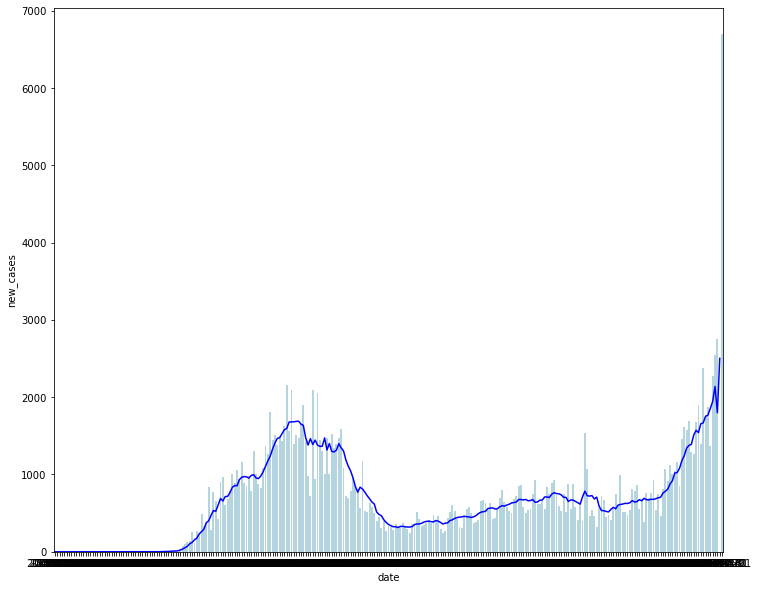

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue');


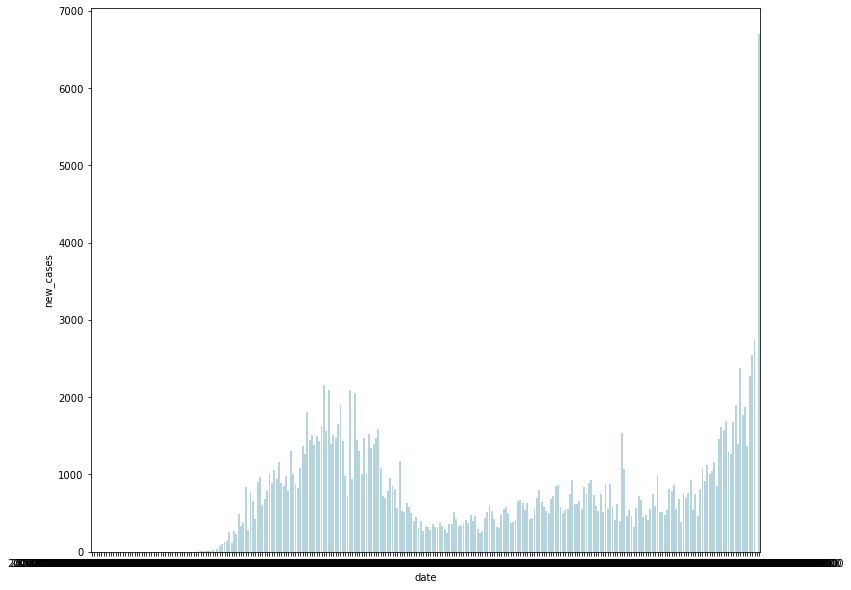

In [30]:
import datetime as dt
import matplotlib.dates as mdates

left = dt.date(2020,1,24)
right = dt.date(2020,10,31)
x = pd.to_datetime(cook['date'])
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
ax1=sns.lineplot(x,y, color = 'blue')
ax2=sns.barplot(x,y2, color = 'lightblue');

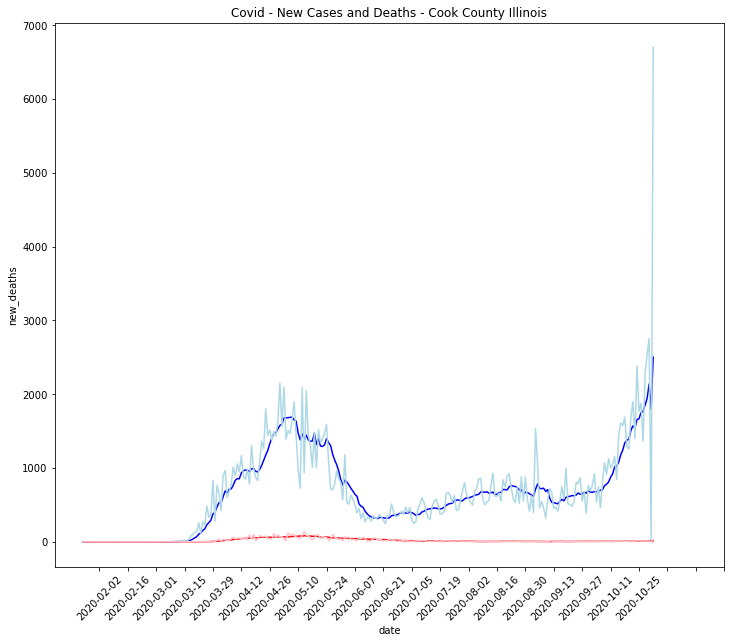

In [31]:
import numpy as np

x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');



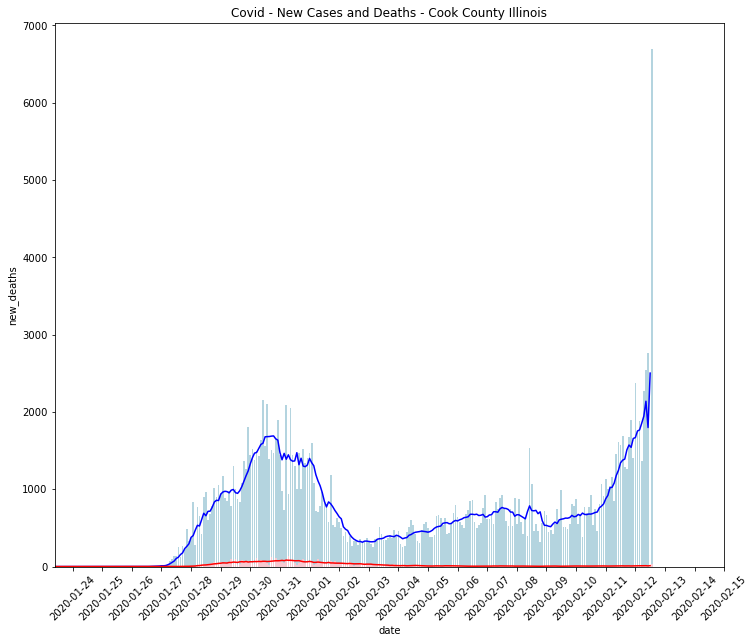

In [32]:
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');